### Importing required libraries

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Rescaling, Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.metrics import Precision, Recall, Accuracy
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from tabulate import tabulate

### Declaring the Variables

In [3]:
IMAGE_SIZE = [256, 256]
BATCH_SIZE=16
FOLDS=10
SCORES_PER_FOLD=[]
CLASSES=["1-1","1-2","1-4","PURE"]

In [4]:
image_dir='/content/drive/MyDrive/Project_2/BLACK_WHITE/WHITE'

In [5]:
logdir='/content/drive/MyDrive/Project_2/CNN_Model_Related/CNN_Model_Related_White/Logs'

In [6]:
model_dir='/content/drive/MyDrive/Project_2/CNN_Model_Related/CNN_Model_Related_White/Model/'

In [7]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

### Fetching and Preprocessing the image files

In [8]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [9]:
image_data_set =tf.keras.utils.image_dataset_from_directory(
  image_dir,
  label_mode='int',
  seed=131,
  image_size=IMAGE_SIZE,
  batch_size=BATCH_SIZE,
)

Found 1120 files belonging to 4 classes.


In [10]:
train_val_set=image_data_set.take(50)
test_set=image_data_set.skip(50).take(20)
print(f'Using {len(train_val_set)} sets for Training and Validation')
print(f'Using {len(test_set)} sets for Testing')

Using 50 sets for Training and Validation
Using 20 sets for Testing


In [11]:
normalized_train_val_set=train_val_set.map(lambda x,y: (normalization_layer(x), y))
normalized_testing_set=test_set.map(lambda x,y: (normalization_layer(x), y))

# image_batch, labels_batch = next(iter(normalized_training_set))      #<-----the data is fethched in this form: image batch, label batch

### Building the CNN Model

In [12]:
def Build_Model():
  model=Sequential()
  
  model.add(Conv2D(32, (3,3), 1, activation='relu', input_shape=(256,256,3)))
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Conv2D(64, (3,3), 1, activation='relu'))
  model.add(MaxPooling2D())

  model.add(Conv2D(64, (3,3), 1, activation='relu'))
  model.add(MaxPooling2D())

  model.add(Conv2D(128, (3,3), 1, activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Flatten())

  model.add(Dense(256, activation='relu'))
  model.add(Dense(4, activation='sigmoid'))

  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  
  return model

In [13]:
# Summary of the model
model=Build_Model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 64)       0

### Peforming the 10 Fold Cross Validation

In [14]:
i=0
j=5
k=45

for fold_var in range(0,FOLDS,1):
  print(f'Fold {fold_var+1}')
  print('--------------------------------------------------------------------------------------------')
  training_set1=normalized_train_val_set.take(i)
  training_set2=normalized_train_val_set.skip(i+j).take(k)
  training_set=training_set1.concatenate(training_set2)
  validation_set=normalized_train_val_set.skip(i).take(j)
  i=i+5
  j=5
  k=k-5
  
  model=Build_Model()
  Model_Run = model.fit(
    training_set,
    epochs=15,
    steps_per_epoch=len(training_set),
    callbacks=[tensorboard_callback]
  )
  print('\n')
  print(f'Evaluating the model')
  print('\n')
  cur_scores=model.evaluate(validation_set)
  cur_scores[0]*=100
  cur_scores[1]*=100
  cur_scores=[fold_var+1,cur_scores[0],cur_scores[1]]
  SCORES_PER_FOLD.append(cur_scores)

  model.save(model_dir+'model_'+str(fold_var+1)+'.h5')
  print('--------------------------------------------------------------------------------------------')
  tf.keras.backend.clear_session()


Fold 1
--------------------------------------------------------------------------------------------
Epoch 1/15
45/45 [==============================] - 98s 1s/step - loss: 0.8699 - accuracy: 0.5875
Epoch 2/15
45/45 [==============================] - 3s 61ms/step - loss: 0.4362 - accuracy: 0.8222
Epoch 3/15
45/45 [==============================] - 4s 63ms/step - loss: 0.3217 - accuracy: 0.8653
Epoch 4/15
45/45 [==============================] - 3s 60ms/step - loss: 0.2503 - accuracy: 0.8958
Epoch 5/15
45/45 [==============================] - 3s 61ms/step - loss: 0.2014 - accuracy: 0.9083
Epoch 6/15
45/45 [==============================] - 4s 73ms/step - loss: 0.2146 - accuracy: 0.9194
Epoch 7/15
45/45 [==============================] - 3s 60ms/step - loss: 0.1590 - accuracy: 0.9361
Epoch 8/15
45/45 [==============================] - 3s 61ms/step - loss: 0.2313 - accuracy: 0.9000
Epoch 9/15
45/45 [==============================] - 4s 60ms/step - loss: 0.1399 - accuracy: 0.9542
Epoch 10/1

In [15]:
column_headers=['Fold Number','Validation Loss(%)','Validation Accuracy(%)']
print(tabulate(SCORES_PER_FOLD, headers=column_headers, tablefmt="grid"))

+---------------+----------------------+--------------------------+
|   Fold Number |   Validation Loss(%) |   Validation Accuracy(%) |
+===============+======================+==========================+
|             1 |             28.583   |                    81.25 |
+---------------+----------------------+--------------------------+
|             2 |              4.66875 |                    98.75 |
+---------------+----------------------+--------------------------+
|             3 |             19.6324  |                    90    |
+---------------+----------------------+--------------------------+
|             4 |             15.954   |                    92.5  |
+---------------+----------------------+--------------------------+
|             5 |              9.02213 |                    97.5  |
+---------------+----------------------+--------------------------+
|             6 |              7.7773  |                    97.5  |
+---------------+----------------------+--------

### Selecting the model with highest accuracy for training

In [16]:
max_acc=SCORES_PER_FOLD[0][2]
max_acc_index=[]
for i in range(len(SCORES_PER_FOLD)):
  if(SCORES_PER_FOLD[i][2]>max_acc):
    max_acc=SCORES_PER_FOLD[i][2]
print(f'The maximum validation accuracy is: {max_acc}')
for i in range(len(SCORES_PER_FOLD)):
  if(SCORES_PER_FOLD[i][2]==max_acc):
    max_acc_index.append(i)
print(f'The folds having {max_acc} validation accuracy are:')
for i in range(len(max_acc_index)):
  print(max_acc_index[i]+1)

result=-1
if(len(max_acc_index)>1):
    min_loss=SCORES_PER_FOLD[max_acc_index[0]][1]
    j=0
    result=max_acc_index[0]
    while(j<len(max_acc_index)):
      index=max_acc_index[j]
      if(SCORES_PER_FOLD[index][1]<min_loss):
        min_loss=SCORES_PER_FOLD[index][1]
        result=index
      j+=1
else:
  result=max_acc_index[0]
print(f'Selecting the model of fold no {result+1} for fine parameter tuning')
model=load_model(model_dir+'model_'+str(result+1)+'.h5')

The maximum validation accuracy is: 98.7500011920929
The folds having 98.7500011920929 validation accuracy are:
2
8
Selecting the model of fold no 2 for fine parameter tuning


### Training the model for fine parameter tuning

In [17]:
training_set=normalized_train_val_set.take(40)
validation_set=normalized_train_val_set.skip(40).take(10)

Cur_Model_Run = model.fit(
    training_set,
    validation_data=validation_set,
    epochs=30,
    steps_per_epoch=len(training_set),
    validation_steps=len(validation_set),
    callbacks=[tensorboard_callback]
  )

Epoch 1/30
40/40 [==============================] - 9s 135ms/step - loss: 0.1854 - accuracy: 0.9297 - val_loss: 0.2632 - val_accuracy: 0.8750
Epoch 2/30
40/40 [==============================] - 6s 150ms/step - loss: 0.3029 - accuracy: 0.8875 - val_loss: 0.3193 - val_accuracy: 0.7937
Epoch 3/30
40/40 [==============================] - 6s 146ms/step - loss: 0.2563 - accuracy: 0.8953 - val_loss: 0.1836 - val_accuracy: 0.9563
Epoch 4/30
40/40 [==============================] - 6s 130ms/step - loss: 0.1425 - accuracy: 0.9469 - val_loss: 0.3420 - val_accuracy: 0.9125
Epoch 5/30
40/40 [==============================] - 5s 129ms/step - loss: 0.4503 - accuracy: 0.8313 - val_loss: 0.2465 - val_accuracy: 0.9000
Epoch 6/30
40/40 [==============================] - 6s 129ms/step - loss: 0.1739 - accuracy: 0.9234 - val_loss: 0.3273 - val_accuracy: 0.8562
Epoch 7/30
40/40 [==============================] - 8s 192ms/step - loss: 0.1388 - accuracy: 0.9594 - val_loss: 0.1489 - val_accuracy: 0.9250
Epoch 

### Plotting the performance of the model after fine parameter tuning

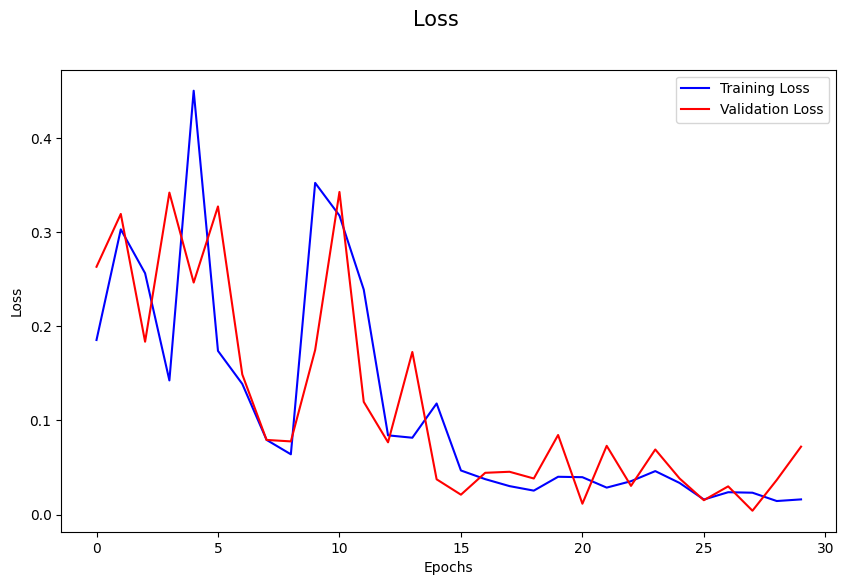

In [18]:
# Plotting the loss


fig=plt.figure(figsize=(10,6));
plt.plot(Cur_Model_Run.history['loss'], color='blue', label='Training Loss')
plt.plot(Cur_Model_Run.history['val_loss'], color='red', label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
fig.suptitle('Loss',fontsize=15)
plt.legend()
plt.show()
fig.savefig('/content/drive/MyDrive/Project_2/CNN_Model_Related/CNN_Model_Related_White/Loss.eps', format='eps', dpi=600)

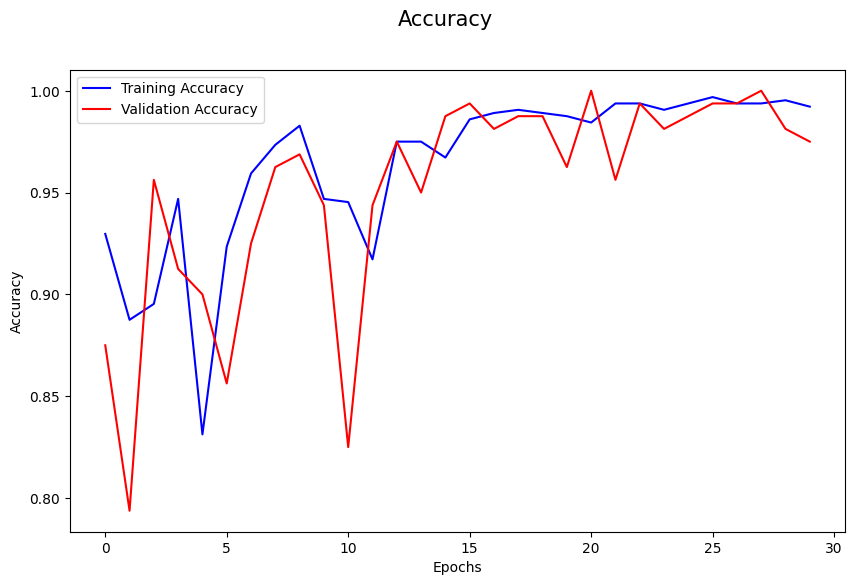

In [19]:
# Plotting the accuracy


fig=plt.figure(figsize=(10,6));
plt.plot(Cur_Model_Run.history['accuracy'], color='blue', label='Training Accuracy')
plt.plot(Cur_Model_Run.history['val_accuracy'], color='red', label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
fig.suptitle('Accuracy',fontsize=15)
plt.legend()
plt.show()
fig.savefig('/content/drive/MyDrive/Project_2/CNN_Model_Related/CNN_Model_Related_White/Accuracy.eps', format='eps', dpi=600)

###Calcualting Precision, Recall, Accuracy and F Score of the Model

In [20]:
pre = Precision()
re = Recall()
acc = Accuracy()

In [21]:
True_label=[]
Predicted_label=[]
score=[]
for images,labels in (normalized_testing_set):              
  score.append(model.evaluate(images,labels))
  for it in range(len(labels)):
    True_label.append(labels[it])
  pred=model.predict(images)
  y_max=[]
  for it in range(len(pred)):
      y_max.append(np.argmax(pred[it]))
      Predicted_label.append(np.argmax(pred[it]))
  pre.update_state(labels,y_max)
  re.update_state(labels,y_max)
  acc.update_state(labels,y_max)

1/1 [==============================] - 0s 40ms/step


In [22]:
f_score=(2*pre.result().numpy()*re.result().numpy())/(pre.result().numpy()+re.result().numpy())

In [23]:
print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}, F Score: {f_score}')

Precision: 1.0, Recall: 0.995708167552948, Accuracy: 0.996874988079071, F Score: 0.99784943911475


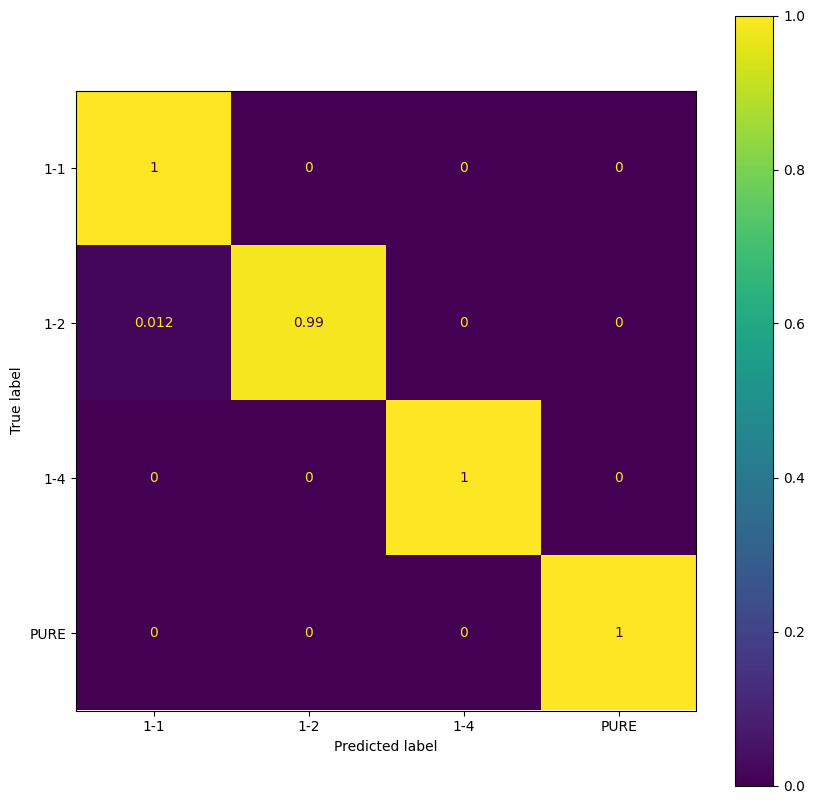

In [24]:
confusion_matrix=metrics.confusion_matrix(True_label,Predicted_label,normalize='true')
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['1-1', '1-2','1-4','PURE'])
fig, ax = plt.subplots(figsize=(10,10))
cm_display.plot(ax=ax)
plt.show();
fig.savefig('/content/drive/MyDrive/Project_2/CNN_Model_Related/CNN_Model_Related_White/Confusion_Matrix.eps', format='eps', dpi=600)

### Demonstrating how to use the model

In [25]:
img=image.load_img('/content/drive/MyDrive/Project_2/BLACK_WHITE/WHITE/1-4/CR_W_DU_1-4_010.jpg',target_size=(256,256))

In [26]:
x=image.img_to_array(img)

In [27]:
x=x/255

In [28]:
x=np.expand_dims(x,axis=0)
x.shape

(1, 256, 256, 3)

In [29]:
pred=model.predict(x)

1/1 [==============================] - 0s 178ms/step


In [30]:
print(pred)

[[3.4873890e-22 2.0207316e-17 1.0000000e+00 1.1857498e-31]]


In [31]:
pred_name = CLASSES[np.argmax(pred)]
print(pred_name)

1-4
